### 👨‍🏭 Albertus Septian Angkuw

### Pembuatan Call Graph

In [3]:
%pip install pycg

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
folderSC = "odoo-16"
currentPath = input("")
print('Current Path set:' ,currentPath)

Current Path set: /home/asa/Documents/Skripsi/TA-1119002/rancangan-dekomposisi


In [2]:
import os
def walkTroughFolder(folderSC,filterExt='.py'):
    listFile = []
    for file in os.listdir(f'{currentPath}/{folderSC}'):
        if os.path.isdir(f'{currentPath}/{folderSC}/{file}'):
            listFile += walkTroughFolder(f'{folderSC}/{file}')
        elif file.endswith(filterExt):
            #print(os.path.join(f'/{folderSC}', file))
            listFile.append(os.path.join(f'/{folderSC}', file))
    return listFile

In [3]:
import time
def scanPyCG(currentPath,package):
    timestamp = int(time.time())
    targetFile = f'py_files=$(find {currentPath}/{package} -type f -name "*.py")'
    execute = f'pycg --package {package} $py_files -o {currentPath}/{package}-{timestamp}.json '
    os.system(f'{targetFile} && {execute}')
    return f'{currentPath}/{package}-{timestamp}.json'

In [4]:
scannedFiles = walkTroughFolder(folderSC)
print(f'Total Files Scanned py Source Code: {len(scannedFiles)}')

Total Files Scanned py Source Code: 5272


In [1]:
# addonsJSON = scanPyCG(currentPath,f'{folderSC}/addons')
# odooJSON = scanPyCG(currentPath,f'{folderSC}/odoo')

In [5]:
addonsJSON = f'{currentPath}/odooOnlyAddonsNoPackage.json'
odooJSON = f'{currentPath}/odooCoreNoPackage.json'

### Pembacaan Hasil Call Graph JSON

In [6]:
import json
def loadJSON(path):
   return json.load(open(path))

In [7]:
cgAddonsSource =loadJSON(addonsJSON)
cgOdooSource =loadJSON(odooJSON)
print(list(cgAddonsSource.values())[:5])
print(list(cgOdooSource.values())[:5])

[[], [], ['odoo.api.depends'], ['odoo.fields.Date.today', 'odoo.models.Model.product_id.with_company', 'odoo.models.Model.browse', '<builtin>.super'], []]
[[], [], [], ['odoo.fields.Char'], []]


In [8]:
len(cgOdooSource)
len(cgAddonsSource)

24931

In [9]:
# Add prefix folder
def getListRootPackage(path):
    listRootPackage = []
    for file in os.listdir(f'{path}'):
        if os.path.isdir(f'{path}/{file}'):
            listRootPackage.append(file)
        elif file.endswith('.py'):
            listRootPackage.append('.'.join(file.split(".")[:-1]))
    return listRootPackage

In [10]:
def addPrefixFolder(cg,root,listPackage):
    def checkParent(key):
        parentkey = key.split('.')[0]
        if parentkey in listPackage:
            key = f'{root}.{key}'
        return key
    newCG = {}
    for key, relation in cg.items():
        key = checkParent(key)
        if key not in newCG:
            newCG[key] = []
        for i in relation:
            newCG[key].append(checkParent(i))
    return newCG

In [11]:
listPackageOdoo = getListRootPackage(f'{currentPath}/{folderSC}/odoo')
listPackageAddons = getListRootPackage(f'{currentPath}/{folderSC}/addons')


In [12]:
cgOdoo = addPrefixFolder(cgOdooSource,"odoo",listPackageOdoo)
cgAddons = addPrefixFolder(cgAddonsSource,"addons",listPackageAddons)

In [17]:
cgSource = {}
for key, rel in cgOdoo.items():
    if key not in cgSource:
        cgSource[key] = []
    for tmp in rel:
        if tmp not in cgSource:
            cgSource[tmp] = []
            # print(key , " : " , cgSource[key])
    cgSource[key] = cgSource[key] + rel

for key, rel in cgAddons.items():
    if key not in cgSource:
        cgSource[key] = []
    for tmp in rel:
        if tmp not in cgSource:
            cgSource[tmp] = []
            # print(key , " : " , cgSource[key])
    cgSource[key] = cgSource[key] + rel

In [18]:
len(cgSource)

29821

### Visualisasi Call Graph

In [46]:
%pip install pygraphviz

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [47]:
import pygraphviz as pgv
def cobaDot():
    d = {"1": {"2": 7 }, "2": {"1": 1, "3": 1, "5" : 1}}
    A = pgv.AGraph(d,strict=False, directed=True)
    A.layout(prog="dot")
    A.draw(f'{currentPath}/contoh-CG.svg') 
    print(A)
#cobaDot()

In [48]:
def buatGraphviz(graph, _strict=False, _directed=True,_prog="fdp",filename=folderSC):
    A = pgv.AGraph(graph,strict=_strict, directed=_directed)
    A.layout(prog=_prog)
    A.draw(f'{currentPath}/{filename}.svg') 
    print(f'Image saved at: {currentPath}/{filename}.svg')

#### Call Graph Raw

In [19]:
callGraphRaw = {}
for key, value in cgSource.items():
    callGraphRaw[key] = {}
    for v in value:
        callGraphRaw[key][v] = 1

In [11]:
# buatGraphviz(graph=callGraphRaw,filename=f'{folderSC}-RAW-CG')

Image saved at: /home/asa/Documents/Skripsi/TA-1119002/rancangan-dekomposisi/asciinema-RAW-CG.svg


#### Filter Call diluar Project

In [37]:
callGraphFiltered = {}
listRootFolder = [ 'odoo', 'addons']
edgeGraph = []
outsideCall = set()
for key, value in cgSource.items():
    rootSource = key.split('.')[0]
    if rootSource not in listRootFolder:
        outsideCall.add(rootSource)
        continue
    childFilter = {}
    for v in value:
        childSource = v.split('.')[0]
        if childSource not in listRootFolder:
            outsideCall.add(childSource)
            continue
        childFilter[v] = 1
    if len(childFilter) == 0:
        edgeGraph.append(key)
        continue
    for c in cgSource:
        if c not in callGraphFiltered:
            callGraphFiltered[c] = {}
    callGraphFiltered[key] = childFilter
    
print(f'Total Top Node: {len(callGraphFiltered)} ')
print(f'Total Edge: {len(edgeGraph)} <{edgeGraph[:3]}>')
print(f'Total OutsideEdge: {len(outsideCall)} <{list(outsideCall)[:3]}>')

Total Top Node: 29821 
Total Edge: 15457 <['odoo.addons.test_inherits_depends.__manifest__', 'odoo.addons.test_inherits_depends.models', 'odoo.fields.Char']>
Total OutsideEdge: 157 <['win32api', 'hashlib', 'json']>


In [58]:
buatGraphviz(callGraphFiltered,filename=f'{folderSC}-CG')

Image saved at: /home/asa/Documents/Skripsi/TA-1119002/rancangan-dekomposisi/odoo-16-CG.svg


In [21]:
cgSource['addons.mrp.models.mrp_routing.MrpRoutingWorkcenter.copy_existing_operations']

['odoo._', 'odoo._', 'odoo._', 'odoo._']

In [22]:
callGraphFiltered['addons.mrp.models.mrp_routing.MrpRoutingWorkcenter.copy_existing_operations']

{'odoo._': 1}

#### Pemberian Weight pada Graph

In [14]:
weightedGraph = {}
weightedGraph[folderSC] = {}
for file in scannedFiles:
    newKey = '.'.join(file[:-3].split("/")[2:])
    weightedGraph[newKey] = {}


In [38]:
weightedGraph = callGraphFiltered

In [16]:
for x in callGraphFiltered:
    if x  in weightedGraph:
        print(x)

asciinema.__main__


In [18]:
currIter = 0
for call, listConn in callGraphFiltered.items():
    if call in weightedGraph:
        print(call , listConn)
        #???
    parentCall = call
    while (parentCall not in weightedGraph):
        parentCall = parentCall.rsplit('.', 1)[0]
    
    for conn, weight in listConn.items():
        parentConn = conn.rsplit('.', 1)[0]
        while (parentConn not in weightedGraph):
            parentConn = parentConn.rsplit('.', 1)[0]
             
        if parentConn not in weightedGraph[parentCall]:
            weightedGraph[parentCall][parentConn] = 1
        else:
            weightedGraph[parentCall][parentConn] += 1
    currIter+=1   


asciinema.__main__ {'asciinema.__main__.main': 1}


In [19]:
buatGraphviz(weightedGraph ,filename=f'{folderSC}-W-CG')

Image saved at: /home/asa/Documents/Skripsi/TA-1119002/rancangan-dekomposisi/asciinema-W-CG.svg


#### Representasi Call Graph menjadi Adjacency Matrix

In [64]:
%pip install numpy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [39]:
import numpy as np
def createAdjacentMatrix(graphSource):
    listLabel = {}
    counterListLabel = 0
    for label in graphSource.keys():
        listLabel[label] = counterListLabel
        counterListLabel+=1
    adjMatrix = np.zeros(shape=(len(listLabel), len(listLabel)))

    currRow = 0
    tmpNotDetected = 0
    for x, connection in graphSource.items():
        for name, weight in connection.items():
            if name not in listLabel:
                # print(x)
                tmpNotDetected += 1
                continue
            adjMatrix[currRow,listLabel[name]] = weight
        currRow+=1 
    print("Not Detected: " , tmpNotDetected)
    return adjMatrix, listLabel

In [40]:
adjMatrix, listLabel = createAdjacentMatrix(weightedGraph)


Not Detected:  0


In [27]:
len(listLabel)

13555

In [41]:
np.savetxt(f'{folderSC}-AdjMatrix.csv', adjMatrix, delimiter=",")

#### Clustering

In [24]:
%pip install scipy
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [43]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, median, centroid, weighted, average, complete, single, fcluster,linkage
from scipy.spatial.distance import pdist

In [26]:
#Normalisasi Data
#sklearn.preprocessing.normalize()

In [44]:
# Source: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

fig, ax = plt.subplots()
im = ax.imshow(adjMatrix)

# Show all ticks and label them with the respective list entries
# ax.set_xticks(np.arange(len(list(listLabel))), labels=list(listLabel))
# ax.set_yticks(np.arange(len(list(listLabel))), labels=list(listLabel))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax.set_title("Heatmap Relation Between Files .py")

# plt.figure(figsize=(20,6))
plt.show()

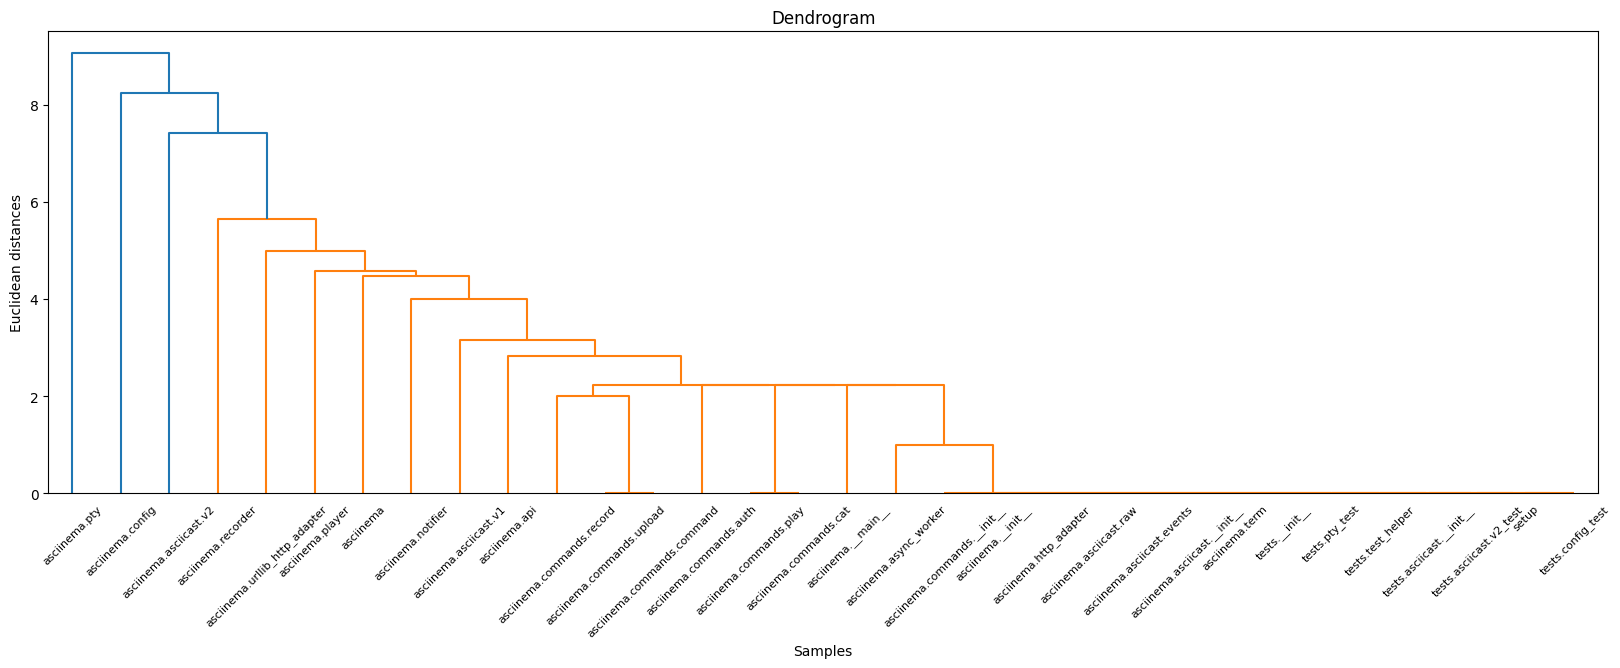

In [28]:
plt.figure(figsize=(20,6))
z = linkage(adjMatrix)
dend = sch.dendrogram(z,labels=list(listLabel))
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean distances')
plt.show()

##### Todo: Pemilihan Cluster Terbaik berdasarkan ....